## Uso de GMM en verificación de locutores

Dado un segmento de voz Y, y un locutor hipotético S, la tarea de la verificación de locutores es determinar si Y fue dicho por S.  
Supondremos siempre que Y siempre tiene locuciones de un solo locutor.

El esquema que utilizaremos es el siguiente:

<img src="Likelihood-SDS.png" alt="Likelihood">

La verificación de locutores puede ser planteada como un test de hipótesis tal que:

$H_0$: Y pertenece al locutor hipotético S 

O bien:

$H_1$: Y no pertenece al locutor hipotético S

La forma óptima de determinar qué hipótesis es verdadera es utilizando el likelihood ratio dado por: 

$$
\frac{p(Y|H_0)}{p(Y|H_1)}=\left\{
        \begin{array}{ll}
            \geq \theta & \quad \textrm{aceptar }  H_0 \\
            < \theta & \quad \textrm{rechazar }  H_0
        \end{array}
    \right.
$$

Donde $\theta$ es el umbral de decisión.

El módulo de front-end se encarga de realizar la extracción de características (features) de la señal de voz. Los modelos a utilizar deben estar representados en función de estos features. Un caso particular de estos features son los coeficientes MFCC ya que están vinculados al modelo de la cóclea, la cual está adaptada particularmente para interpretar la voz humana. Otra posibilidad que se utiliza para verificación de locutores son los coeficientes LPC los cuales contienen información acerca de como la señal es generada por el aparato fonador. Adicionalmente, el módulo de front-end puede contener un VAD, un supresor de ruido y un filtro de preénfasis. El VAD es muy útil ya que permite que uno no tenga en consideración muchas muestras que aportarían ceros generando un corrimiento de los parámetros estadísticos. Además para nuestro caso, el silencio forma parte de la mayoría de las locuciones, lo cual atenta en contra de la discriminación entre características. Los valores del MFCCs no son muy robustos ante la presencia de ruido aditivo, por ello es común que se implemente una etapa de supresión de ruido, o ligeras modificaciones de MFCC. Por último la señal de voz contiene información en sus altas frecuencias (las cuales tienen tasas de variación mas altas) que las señales de bajas frecuencias. Es por ello que se suele considerar un filtro de preénfasis. El filtro de preénfasis mas utilizado tiene la forma: 

$$ y(n)=x(n)-\alpha.x(n-1), \textrm{ con }0.9 < \alpha < 0.97 $$

Una pregunta que puede surgir en este momento es cuál es la conveniencia de utilizar MFCC (con la DCT en el bloque final del proceso) en vez de utilizar un banco de filtros logarítmico. Para responder esto, ya vamos adelantando que la forma de modelar tanto al modelo de mundo como al modelo del locutor se hará utilizando GMM. GMM mejora mucho su performance si cada una de sus variables es independiente. En general se observa que la etapa de DCT elimina dependencia entre los coeficientes MFCC, mejorando el rendimiento del sistema. Esta es una de las razones de peso por las cuales MFCC tiene una DCT a la salida y no una IFFT.

Para mas información con respecto a la generación de los coeficientes MFCC se recomienda ver este [link](http://www.practicalcryptography.com/miscellaneous/machine-learning/guide-mel-frequency-cepstral-coefficients-mfccs/)

A continunación, vayamos implementando la etapa de preprocesamiento. 

In [105]:
import collections
import contextlib
import sys
import wave
import os
import webrtcvad


def read_wave(path):
    with contextlib.closing(wave.open(path, 'rb')) as wf:
        num_channels = wf.getnchannels()
        assert num_channels == 1
        sample_width = wf.getsampwidth()
        assert sample_width == 2
        sample_rate = wf.getframerate()
        assert sample_rate in (8000, 16000, 32000)
        pcm_data = wf.readframes(wf.getnframes())
        return pcm_data, sample_rate


def write_wave(path, audio, sample_rate):
    with contextlib.closing(wave.open(path, 'wb')) as wf:
        wf.setnchannels(1)
        wf.setsampwidth(2)
        wf.setframerate(sample_rate)
        wf.writeframes(audio)


class Frame(object):
    def __init__(self, bytes, timestamp, duration):
        self.bytes = bytes
        self.timestamp = timestamp
        self.duration = duration


def frame_generator(frame_duration_ms, audio, sample_rate):
    n = int(sample_rate * (frame_duration_ms / 1000.0) * 2)
    offset = 0
    timestamp = 0.0
    duration = (float(n) / sample_rate) / 2.0
    while offset + n < len(audio):
        yield Frame(audio[offset:offset + n], timestamp, duration)
        timestamp += duration
        offset += n


def vad_collector(sample_rate, frame_duration_ms,
                  padding_duration_ms, vad, frames):
    num_padding_frames = int(padding_duration_ms / frame_duration_ms)
    ring_buffer = collections.deque(maxlen=num_padding_frames)
    triggered = False
    voiced_frames = []
    for frame in frames:
        sys.stdout.write(
            '1' if vad.is_speech(frame.bytes, sample_rate) else '0')
        if not triggered:
            ring_buffer.append(frame)
            num_voiced = len([f for f in ring_buffer
                              if vad.is_speech(f.bytes, sample_rate)])
            if num_voiced > 0.9 * ring_buffer.maxlen:
                sys.stdout.write('+(%s)' % (ring_buffer[0].timestamp,))
                triggered = True
                voiced_frames.extend(ring_buffer)
                ring_buffer.clear()
        else:
            voiced_frames.append(frame)
            ring_buffer.append(frame)
            num_unvoiced = len([f for f in ring_buffer
                                if not vad.is_speech(f.bytes, sample_rate)])
            if num_unvoiced > 0.9 * ring_buffer.maxlen:
                sys.stdout.write('-(%s)' % (frame.timestamp + frame.duration))
                triggered = False
                yield b''.join([f.bytes for f in voiced_frames])
                ring_buffer.clear()
                voiced_frames = []
    if triggered:
        sys.stdout.write('-(%s)' % (frame.timestamp + frame.duration))
    sys.stdout.write('\n')
    if voiced_frames:
        yield b''.join([f.bytes for f in voiced_frames])


def chunk(file, agressiveness):
    path_out="./chunks/"
    audio, sample_rate = read_wave(file)
    vad = webrtcvad.Vad(int(agressiveness))
    frames = frame_generator(30, audio, sample_rate)
    frames = list(frames)
    segments = vad_collector(sample_rate, 30, 300, vad, frames)
    try:
        os.stat(path_out+".".join(file.split(".")[:-1]))
    except:
        os.mkdir(path_out+".".join(file.split(".")[:-1]))
    for i, segment in enumerate(segments):
        path = path_out+ ".".join(file.split(".")[:-1])+'/chunk-%002d.wav' % (i,)
        print(' Writing %s' % (path,))
        write_wave(path, segment, sample_rate)


chunk("dolina.wav", 1)

1100111111+(0.0)11111111111111111111111111111111111111111111111111111110001111111111111111111111111111000000-(3.0599999999999947)
 Writing ./chunks/dolina/chunk-00.wav


En función de los archivos que generamos anteriormente, podemos calcular sus MFCC. Algunas consideraciones sobre el paquete [python_speech_features](http://python-speech-features.readthedocs.io/en/latest/index.html#):

* Ya aplica filtro de preenfasis
* si bien calcua los 26 MFCC solo devuelve los primeros 13, los cuales son los mas importantes para la verificación de locutores.
* appendEnergy pone en el bin 1 de los features el logaritmo de la energía. Esto ocurre ya que en general se descartan los 2 o 3 primeros elementos de los MFCC ya que no se ve un aumento significativo del score y sí se ve un aumento en el score si agrego a mi modelo el logaritmo de la energía del frame. Para mas información se recomienda leer este [paper](http://ai2-s2-pdfs.s3.amazonaws.com/6f14/5968059d006235d59d1c201d5185b440d221.pdf).

Adicionalmente se suelen aplicar algunos liftros y los features conocidos como delta y delta-delta como veremos mas adelante.

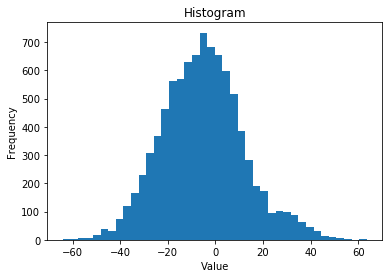

[[  8.19296586 -30.81203634  21.12103847 ...,  -7.23742251   2.22254066
   -0.44072562]
 [  8.2735939  -36.54609875  23.69603008 ...,  -4.15684418  -0.8209452
   -1.62943819]
 [  7.98226232 -46.13965039  22.97692025 ...,  -3.19703806  -0.45735365
    1.31570582]
 ..., 
 [ 10.46374387  -7.48668899 -14.47816951 ...,   5.85006495   2.18201576
   -3.87457837]
 [ 10.38563971  -5.2875572  -15.47857569 ...,   5.12528364   7.40194908
   -3.99840064]
 [  9.74645596  -1.9334523  -12.62405377 ...,   7.19644899  11.91990837
   -5.03046396]]


In [244]:
from python_speech_features import mfcc 
from python_speech_features import logfbank
from python_speech_features import base
import scipy.io.wavfile as wav
import matplotlib.pyplot as plt
import numpy as np
from sklearn import mixture
import itertools
from scipy import linalg
import matplotlib as mpl

def mfcc_wav(file):
    (rate,sig) = wav.read(file)
    mfcc_feat = mfcc(sig,rate,nfft=512,appendEnergy=True)
    #fbank_feat = logfbank(sig,rate,nfft=512)
    return mfcc_feat

mfcc_feat=mfcc_wav("mundo.wav")
plt.hist(mfcc_feat.T[5], bins=40)
plt.title("Histogram")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()
print(mfcc_feat)

En función de lo visto en los histogramas anteriores, se suelen modelar las características (features) de un locutor o del UBM utilizando GMM. Llamaremos al modelo de S $\lambda_{hyp}$ y al modelo del UBM $\lambda_{\overline{hyp}}$.  
También se suele utilizar el log-likelihood en vez del likelihood ya que muchas veces el likelihood toma valores muy pequeños y se puede llegar a perder en la precisión del int (se puede ver que a medida que aumenta la cantidad de parámetros el likelihood baja cada vez mas):

$$ \Lambda (X) = \log p(X|\lambda_{hyp}) - \log p(X|\lambda_{\overline{hyp}}) $$

El modelo del locutor en general está bien definido y puede estimarse utilizando muestras de S. El modelo $\lambda_{\overline{hyp}}$ en general no está tan bien definido ya que debe representar a todo el espacio de locutores que no es el locutor hipotético. 

Para modelar la hipótesis alternativa se puede utilizar un gran número de locutores que no sean el locutor hipotético. A estos locutores se los conoce como los background speakers. Dado un grupo de N modelos de background speakers ${\lambda_1, \lambda_2, \lambda_3, ... , \lambda_N}$ la hipótesis alternativa se puede representar con:

$$ p(X|\lambda_{\overline{hyp}})=F(p(X|\lambda_1), p(X|\lambda_2), ... , p(X|\lambda_N)) $$

donde F() es una función que puede representar el promedio o el máximo de los valores de likelihood de cada uno de los background speakers. La complicación de este método es que requiere que tenga un modelo para cada uno de los background speakers lo cual para un gran número de background speakers conlleva la utilización de muchos recursos.

El método alternativo es tomar muestras de distintos locutores y entrenar un modelo único. A este modelo se lo conoce como modelo de mundo, modelo general, o UBM. De esta forma solo es necesario entrenar un modelo único $\lambda_{bkg}$. Existen variaciones como utilizar distintos UBM de acuerdo a qué locutor quiero validar pero en nuestro caso utilizaremos uno solo.

Para modelar el UBM se utiliza GMM y para entrenar el modelo se utiliza EM (Expectation Maximization).

GMM es un modelo conceptualmente muy sencillo y se puede tener información [acá](http://scikit-learn.org/stable/modules/mixture.html) y [acá](http://practicalcryptography.com/miscellaneous/machine-learning/gaussian-mixture-model-tutorial/). O por supuesto, está de referencia el llamado [paper1](http://ai2-s2-pdfs.s3.amazonaws.com/6e0e/1a22a43eaf2fd10394ea6abefc32f161b989.pdf)

Para comprender conceptualmente EM, se recomienda ver este [video](https://www.youtube.com/watch?v=7e65vXZEv5Q) o ver este [paper](http://ai.stanford.edu/~chuongdo/papers/em_tutorial.pdf), pero para una comprensión precisa de EM en nuestro contexto, lo mas aconsejable es ver este [paper](http://www.cs.toronto.edu/~frank/csc401/readings/ReynoldsRose.pdf)

In [173]:
mfcc_feat.shape

(9018, 13)

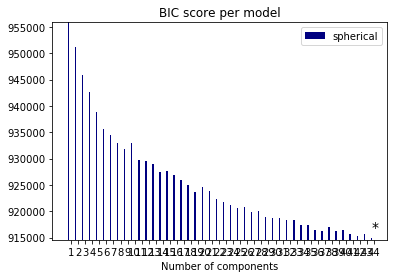

In [245]:
lowest_bic = np.infty
bic = []
n_components_range = range(1, 45)
cv_types = ['spherical']#, 'tied', 'diag', 'full']
for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gmm = mixture.GaussianMixture(n_components=n_components,
                                      covariance_type=cv_type)
        gmm.fit(mfcc_feat)
        bic.append(gmm.bic(mfcc_feat))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm_mundo = gmm

bic = np.array(bic)
color_iter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue',
                              'darkorange'])
clf = best_gmm_mundo
bars = []

# Plot the BIC scores
spl = plt.subplot(1, 1, 1)
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + .2 * (i - 2)
    bars.append(plt.bar(xpos, bic[i * len(n_components_range):
                                  (i + 1) * len(n_components_range)],
                        width=.2, color=color))
plt.xticks(n_components_range)
plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
plt.title('BIC score per model')
xpos = np.mod(bic.argmin(), len(n_components_range)) + .65 +\
    .2 * np.floor(bic.argmin() / len(n_components_range))
plt.text(xpos, bic.min() * 0.97 + .03 * bic.max(), '*', fontsize=14)
spl.set_xlabel('Number of components')
spl.legend([b[0] for b in bars], cv_types)
Y_ = clf.predict(mfcc_feat)
#plt.subplots_adjust(hspace=1, bottom=1)
plt.show()

Nos vamos a quedar con la estimación de 6 parámetros. Veamos cuáles son esos parámetros:

In [175]:
best_gmm_mundo.get_params()

{'covariance_type': 'spherical',
 'init_params': 'kmeans',
 'max_iter': 100,
 'means_init': None,
 'n_components': 44,
 'n_init': 1,
 'precisions_init': None,
 'random_state': None,
 'reg_covar': 1e-06,
 'tol': 0.001,
 'verbose': 0,
 'verbose_interval': 10,
 'warm_start': False,
 'weights_init': None}

Tomemos ahora un audio particular y calculemos el likelihood de que ese audio haya sido generado por el modelo de mundo:

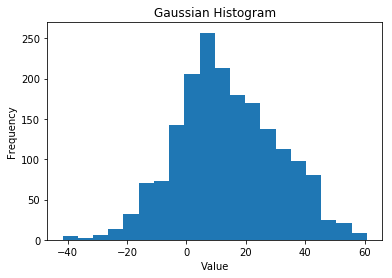

-55.121497140320237

In [247]:
mfcc_feat=mfcc_wav("homero.wav")
plt.hist(mfcc_feat.T[3], bins=20)
plt.title("Gaussian Histogram")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()
best_gmm_mundo.score(mfcc_feat)

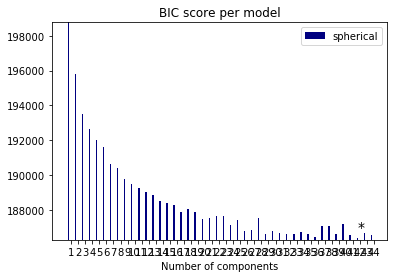

In [248]:
lowest_bic = np.infty
bic = []
n_components_range = range(1, 45)
cv_types = ['spherical']#, 'tied', 'diag', 'full']
for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gmm = mixture.GaussianMixture(n_components=n_components,
                                      covariance_type=cv_type)
        gmm.fit(mfcc_feat)
        bic.append(gmm.bic(mfcc_feat))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm_homero = gmm

bic = np.array(bic)
color_iter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue',
                              'darkorange'])
clf = best_gmm_homero
bars = []

# Plot the BIC scores
spl = plt.subplot(1, 1, 1)
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + .2 * (i - 2)
    bars.append(plt.bar(xpos, bic[i * len(n_components_range):
                                  (i + 1) * len(n_components_range)],
                        width=.2, color=color))
plt.xticks(n_components_range)
plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
plt.title('BIC score per model')
xpos = np.mod(bic.argmin(), len(n_components_range)) + .65 +\
    .2 * np.floor(bic.argmin() / len(n_components_range))
plt.text(xpos, bic.min() * 0.97 + .03 * bic.max(), '*', fontsize=14)
spl.set_xlabel('Number of components')
spl.legend([b[0] for b in bars], cv_types)
Y_ = clf.predict(mfcc_feat)
plt.show()

In [178]:
best_gmm_homero.score(mfcc_feat)

-49.365063275676313

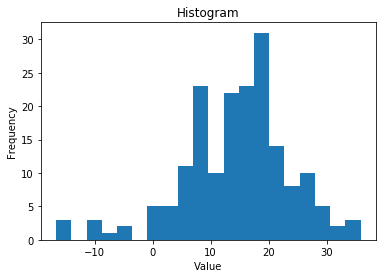

-52.80854727172904

In [249]:
mfcc_feat=mfcc_wav("homero_test.wav")
plt.hist(mfcc_feat.T[3], bins=20)
plt.title("Histogram")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()
best_gmm_homero.score(mfcc_feat)

In [250]:
best_gmm_mundo.score(mfcc_feat)

-56.196126163068129

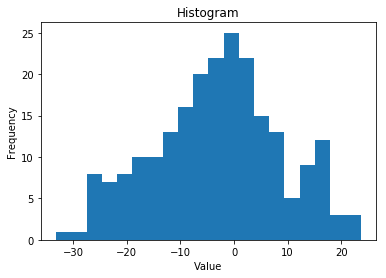

-53.612730024152064

In [252]:
mfcc_feat=mfcc_wav("mundo_test_1.wav")
plt.hist(mfcc_feat.T[3], bins=20)
plt.title("Histogram")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()
best_gmm_homero.score(mfcc_feat)

In [182]:
best_gmm_mundo.score(mfcc_feat)

-52.166978036252537

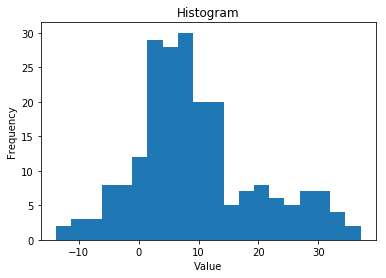

-52.675135459965801

In [253]:
mfcc_feat=mfcc_wav("homero_test_2.wav")
plt.hist(mfcc_feat.T[3], bins=20)
plt.title("Histogram")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()
best_gmm_homero.score(mfcc_feat)

In [254]:
best_gmm_mundo.score(mfcc_feat)

-55.518888698331665

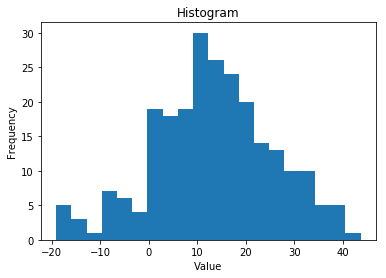

-51.09207009781926

In [255]:
mfcc_feat=mfcc_wav("homero_test_3.wav")
plt.hist(mfcc_feat.T[3], bins=20)
plt.title("Histogram")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()
best_gmm_homero.score(mfcc_feat)

In [186]:
best_gmm_mundo.score(mfcc_feat)

-56.400511623605887

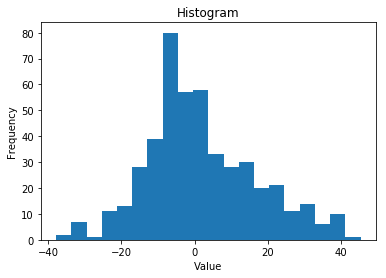

-56.044594948661427

In [187]:
mfcc_feat=mfcc_wav("mundo_test_2.wav")
plt.hist(mfcc_feat.T[3], bins=20)
plt.title("Histogram")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()
best_gmm_homero.score(mfcc_feat)

In [188]:
best_gmm_mundo.score(mfcc_feat)

-52.602962431011782

Ahora incluiremos las componentes delta y delta delta en la lista de features

In [212]:
mfcc_feat=mfcc_wav("mundo.wav")
mfcc_delta=base.delta(mfcc_feat,2)
mfcc_delta_delta=base.delta(mfcc_delta,2)
mfcc_feat=np.hstack([mfcc_feat, mfcc_delta, mfcc_delta_delta])
print(mfcc_feat.shape)


(9018, 39)


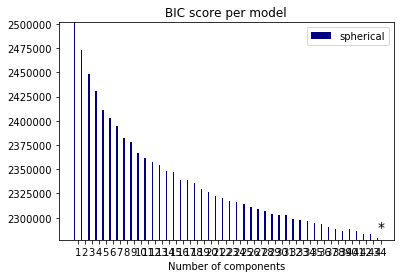

In [213]:
lowest_bic = np.infty
bic = []
n_components_range = range(1, 45)
cv_types = ['spherical']#, 'tied', 'diag', 'full']
for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gmm = mixture.GaussianMixture(n_components=n_components,
                                      covariance_type=cv_type)
        gmm.fit(mfcc_feat)
        bic.append(gmm.bic(mfcc_feat))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm_mundo = gmm

bic = np.array(bic)
color_iter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue',
                              'darkorange'])
clf = best_gmm_mundo
bars = []

# Plot the BIC scores
spl = plt.subplot(1, 1, 1)
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + .2 * (i - 2)
    bars.append(plt.bar(xpos, bic[i * len(n_components_range):
                                  (i + 1) * len(n_components_range)],
                        width=.2, color=color))
plt.xticks(n_components_range)
plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
plt.title('BIC score per model')
xpos = np.mod(bic.argmin(), len(n_components_range)) + .65 +\
    .2 * np.floor(bic.argmin() / len(n_components_range))
plt.text(xpos, bic.min() * 0.97 + .03 * bic.max(), '*', fontsize=14)
spl.set_xlabel('Number of components')
spl.legend([b[0] for b in bars], cv_types)
Y_ = clf.predict(mfcc_feat)
#plt.subplots_adjust(hspace=1, bottom=1)
plt.show()

In [214]:
best_gmm_mundo.score(mfcc_feat)

-125.46832044098355

In [215]:
mfcc_feat=mfcc_wav("homero.wav")
mfcc_delta=base.delta(mfcc_feat,2)
mfcc_delta_delta=base.delta(mfcc_delta,2)
mfcc_feat=np.hstack([mfcc_feat, mfcc_delta, mfcc_delta_delta])
print(mfcc_feat.shape)

(1854, 39)


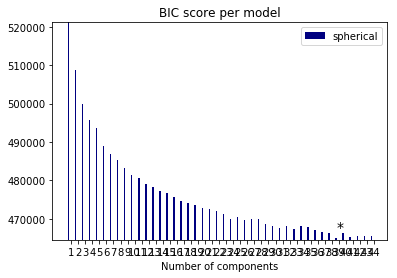

In [216]:
lowest_bic = np.infty
bic = []
n_components_range = range(1, 45)
cv_types = ['spherical']#, 'tied', 'diag', 'full']
for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gmm = mixture.GaussianMixture(n_components=n_components,
                                      covariance_type=cv_type)
        gmm.fit(mfcc_feat)
        bic.append(gmm.bic(mfcc_feat))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm_homero = gmm

bic = np.array(bic)
color_iter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue',
                              'darkorange'])
clf = best_gmm_homero
bars = []

# Plot the BIC scores
spl = plt.subplot(1, 1, 1)
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + .2 * (i - 2)
    bars.append(plt.bar(xpos, bic[i * len(n_components_range):
                                  (i + 1) * len(n_components_range)],
                        width=.2, color=color))
plt.xticks(n_components_range)
plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
plt.title('BIC score per model')
xpos = np.mod(bic.argmin(), len(n_components_range)) + .65 +\
    .2 * np.floor(bic.argmin() / len(n_components_range))
plt.text(xpos, bic.min() * 0.97 + .03 * bic.max(), '*', fontsize=14)
spl.set_xlabel('Number of components')
spl.legend([b[0] for b in bars], cv_types)
Y_ = clf.predict(mfcc_feat)
plt.show()

In [219]:
best_gmm_homero.score(mfcc_feat)

-122.18756334964657

In [220]:
best_gmm_mundo.score(mfcc_feat)

-138.84059438451797

In [222]:
mfcc_feat=mfcc_wav("homero_test.wav")
mfcc_delta=base.delta(mfcc_feat,2)
mfcc_delta_delta=base.delta(mfcc_delta,2)
mfcc_feat=np.hstack([mfcc_feat, mfcc_delta, mfcc_delta_delta])
print("Score Mundo:")
print(best_gmm_mundo.score(mfcc_feat))
print("Score Homero:")
print(best_gmm_homero.score(mfcc_feat))

Score Mundo:
-140.826647169
Score Homero:
-131.674275782


In [223]:
mfcc_feat=mfcc_wav("mundo_test_1.wav")
mfcc_delta=base.delta(mfcc_feat,2)
mfcc_delta_delta=base.delta(mfcc_delta,2)
mfcc_feat=np.hstack([mfcc_feat, mfcc_delta, mfcc_delta_delta])
print("Score Mundo:")
print(best_gmm_mundo.score(mfcc_feat))
print("Score Homero:")
print(best_gmm_homero.score(mfcc_feat))

Score Mundo:
-130.38116435
Score Homero:
-134.596324895


In [224]:
mfcc_feat=mfcc_wav("mundo_test_2.wav")
mfcc_delta=base.delta(mfcc_feat,2)
mfcc_delta_delta=base.delta(mfcc_delta,2)
mfcc_feat=np.hstack([mfcc_feat, mfcc_delta, mfcc_delta_delta])
print("Score Mundo:")
print(best_gmm_mundo.score(mfcc_feat))
print("Score Homero:")
print(best_gmm_homero.score(mfcc_feat))

Score Mundo:
-131.524173886
Score Homero:
-141.242924218


In [232]:
mfcc_feat=mfcc_wav("homero_test_2.wav")
mfcc_delta=base.delta(mfcc_feat,2)
mfcc_delta_delta=base.delta(mfcc_delta,2)
mfcc_feat=np.hstack([mfcc_feat, mfcc_delta, mfcc_delta_delta])
print("Score Mundo:")
print(best_gmm_mundo.score(mfcc_feat))
print("Score Homero:")
print(best_gmm_homero.score(mfcc_feat))

Score Mundo:
-138.40015891
Score Homero:
-130.535296475


In [230]:
mfcc_feat=mfcc_wav("homero_test_3.wav")
mfcc_delta=base.delta(mfcc_feat,2)
mfcc_delta_delta=base.delta(mfcc_delta,2)
mfcc_feat=np.hstack([mfcc_feat, mfcc_delta, mfcc_delta_delta])
print("Score Mundo:")
print(best_gmm_mundo.score(mfcc_feat))
print("Score Homero:")
print(best_gmm_homero.score(mfcc_feat))

Score Mundo:
-140.022235995
Score Homero:
-127.94917763


In [233]:
mfcc_feat=mfcc_wav("homero_test_3.wav")
mfcc_delta=base.delta(mfcc_feat,2)
mfcc_delta_delta=base.delta(mfcc_delta,2)
mfcc_feat=np.hstack([mfcc_feat, mfcc_delta, mfcc_delta_delta])
print("Score Mundo:")
print(best_gmm_mundo.score(mfcc_feat))
print("Score Homero:")
print(best_gmm_homero.score(mfcc_feat))

Score Mundo:
-140.022235995
Score Homero:
-127.94917763
